In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using JuMP
using Ipopt
using Statistics
using Random

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [2]:
include("unicycle_env.jl")
include("problem.jl")
include("controller.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [3]:
function tracking(tp::TP, ctrl; verbose=false, only_one_step=false)
    x = tp.x0
    X = [copy(tp.x0) for k = 1:tp.T]
    U = [zeros(2) for k = 1:tp.T-1]
    safe_sets = []
    tot_time = 0
    for i in 1:tp.T-1
        if only_one_step
            x = tp.Xref[i]
        end
        xref = tp.Xref[i+1]
        timed_result = @timed get_control(ctrl, xref, x, tp.net, tp.obj_cost, tp.dt)
        u, safe_set = timed_result.value
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        x = forward(tp.net, x, u, tp.dt)
        X[i+1] = x
        U[i] = u
        cost = sum(abs.(x - xref).*tp.obj_cost)
        if verbose
            @show xref-x
            @show cost
        end
    end
    tot_error = sum(costs(tp,X))
    if verbose
        @show tot_time
        @show tot_error
    end
    return X, U, tot_time
end

function tracking_stat(net, obj_cost, tf, Xrefs, ctrl; verbose=false, only_one_step=false)
    all_costs = []
    tot_time = 0
    for i = 1:length(Xrefs)
        Xref = Xrefs[i]
        tp = TP(net, obj_cost, tf, Xref);
        Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=only_one_step)
        all_costs = [all_costs; costs(tp, Xtrack)]
        tot_time += time
        mean_cost = mean(costs(tp, Xtrack))
        std_cost = std(costs(tp, Xtrack))
        if verbose
            @show mean_cost, std_cost, time
        end
    end
    mean_cost = mean(all_costs)
    std_cost = std(all_costs)
    return mean_cost, std_cost, tot_time
end

tracking_stat (generic function with 1 method)

In [20]:
function nn_dynamics_tracking_state(net_path, tf, T, num, ctrls, ctrl_names; only_one_step=false, plot_traj=false, only_MIND=false)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(127);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    if plot_traj
        p = plot()
        for k = 1:length(Xrefs)
            xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
            ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
            plot!(xs, ys, legend = false)
        end
        display(p)
    end
    
    
    err_bound = [1, 1, 0.1, 0.1]
    nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_1000 = ShootingController(1000);
    shoot_10000 = ShootingController(10000);
    shoot_100000 = ShootingController(100000);
    ctrl_names = ["MIND", "shoot_1000", "shoot_10000", "shoot_100000", "nl_ctrl"]
    ctrls = [nv_ctrl, shoot_1000, shoot_10000, shoot_100000, nl_ctrl]
    if only_MIND
        ctrl_names = ["MIND"]
        ctrls = [nv_ctrl]
    end

    mean_costs = []
    std_costs = []
    avg_times = []
    for i in 1:length(ctrls)
        name = ctrl_names[i]
        ctrl = ctrls[i]
        mean_cost, std_cost, tot_time = tracking_stat(net, obj_cost, tf, Xrefs, ctrl, only_one_step=only_one_step)
        avg_time = tot_time/(tf * T * num)
        @show name, mean_cost, std_cost, avg_time
        push!(mean_costs, mean_cost)
        push!(std_costs, std_cost)
        push!(avg_times, avg_time)
    end
    return mean_costs, std_costs, avg_times
end

nn_dynamics_tracking_state (generic function with 2 methods)

In [5]:
function get_input_samples()
    nx = 11
    ny = 11
    nv = 11
    nt = 11
    nu = 11
    xs = range(-5,stop=5,length=nx)
    ys = range(-5,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    u1s = range(-4,stop=4,length=nu)
    u2s = range(-π,stop=π,length=nu)
    samples = [[x,y,v,θ, u1, u2] for x in xs, y in ys, v in vs, θ in θs, u1 in u1s, u2 in u2s];
    return samples
end
input_samples = get_input_samples();

In [8]:
function model_mismatch(net_path, input_samples)
    net = read_nnet(net_path);
    errors = []
    gts = []
    nts = []
    for input in input_samples
        gt_dot_x = traj_rk4(input[1:4], input[5:6], 0.1)
        net_dot_x = compute_output(net, input)
        push!(gts, gt_dot_x)
        push!(nts, net_dot_x)
    end
    return gts, nts
end

model_mismatch (generic function with 1 method)

In [27]:

function tracking_stat(layers, hidden, tf, T, num, only_MIND)
    @assert length(layers) == length(hidden)

    mmes = []
    ats = []
    for i in 1:length(layers)
        net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
        gts, nts = model_mismatch(net_path, input_samples)
        a = norm.(gts-nts)
        mean_modeling_error = mean(a)
        @show  layers[i], hidden[i], mean_modeling_error
        mean_costs, std_costs, avg_times = nn_dynamics_tracking_state(net_path, tf, T, num, ctrls, ctrl_names; only_MIND=only_MIND)
        for j in 1:length(ctrl_names)
            @show  ctrl_names[j], mean_costs[j], std_costs[j], avg_times[j]
        end
    end
    return mmes, ats
end

tracking_stat (generic function with 3 methods)

In [31]:
include("controller.jl")

get_control (generic function with 5 methods)

In [32]:
# Generalizability of MIND to different network size.
layers = [2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5]
hidden = [50, 100, 200, 300, 500, 1000, 50, 100, 200, 300, 50, 100, 200, 50, 100]
tracking_stat(layers, hidden, 1, 10, 5, true)

(layers[i], hidden[i], mean_modeling_error) = (2, 50, 0.27552893186844896)
(ctrl_names[j], mean_costs[j], std_costs[j], avg_times[j]) = ("MIND", 9.594550124253365e-9, 1.83212461574977e-8, 0.0320152739)
(layers[i], hidden[i], mean_modeling_error) = (2, 100, 0.19887079441090091)


LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 214 and 114")[39m

In [35]:
# Compare different solvers under three different NNDM.
layers = [2]
hidden = [100]
tracking_stat(layers, hidden, 1, 10, 5, true)

(layers[i], hidden[i], mean_modeling_error) = (2, 100, 0.19887079441090091)
(ctrl_names[j], mean_costs[j], std_costs[j], avg_times[j]) = ("MIND", 9.531502894463348e-5, 0.0005306145943204558, 0.09779374774)


(Any[], Any[])

In [33]:
# Compare different solvers under three different NNDM.
layers = [3, 3, 4]
hidden = [50, 100, 50]
tracking_stat(layers, hidden, 1, 10, 50, false)

(layers[i], hidden[i], mean_modeling_error) = (3, 50, 0.1509922031045889)


LoadError: [91mInterruptException:[39m

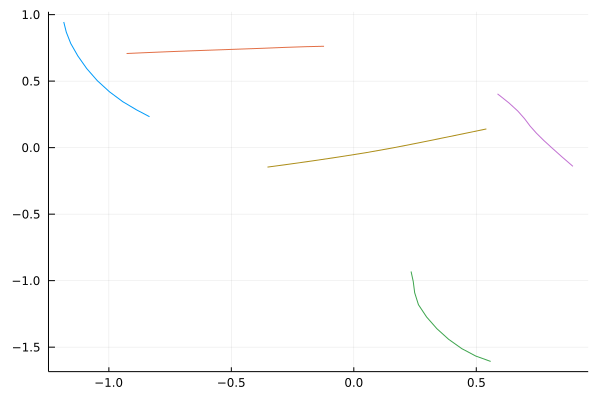

(layers[i], hidden[i]) = (4, 100)
(mean_cost, std_cost, tot_time) = (1.1729546626759735e-8, 3.028332567549409e-8, 239.97875070499998)


In [11]:
layers = [4]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [7]:
layers = [4]
hidden = [200]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

(layers[i], hidden[i]) = (4, 200)


LoadError: [91mSystemError: opening file "../nnet/unicycle-FC4-200-rk4-extra/epoch_1000.nnet": No such file or directory[39m

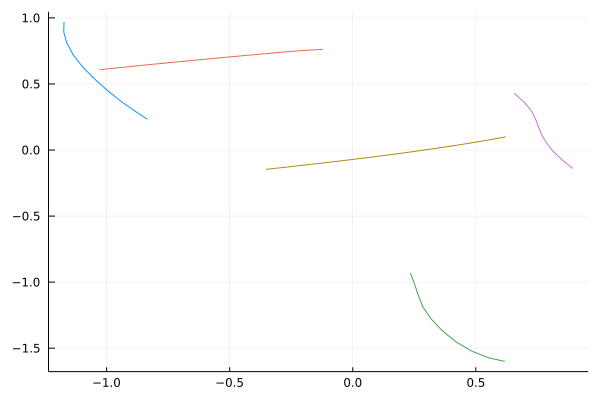

(layers[i], hidden[i]) = (5, 50)
(mean_cost, std_cost, tot_time) = (9.286669568203676e-9, 1.54267027992548e-8, 111.18268018200001)


In [53]:
layers = [5]
hidden = [50]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [54]:
111.18268018200001/50

2.2236536036400003

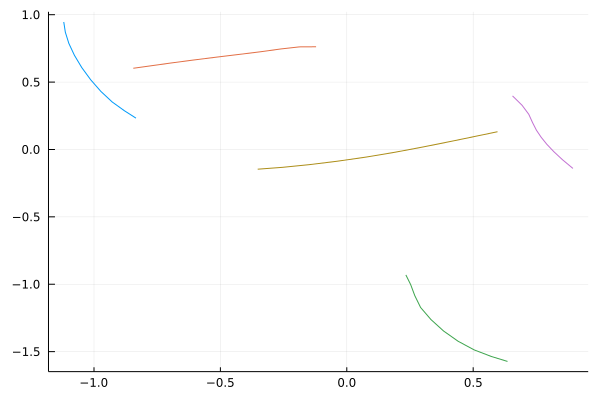

(layers[i], hidden[i]) = (5, 100)
(mean_cost, std_cost, tot_time) = (9.252995607778036e-9, 1.5094927402049486e-8, 1440.967892535)


In [12]:
layers = [5]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

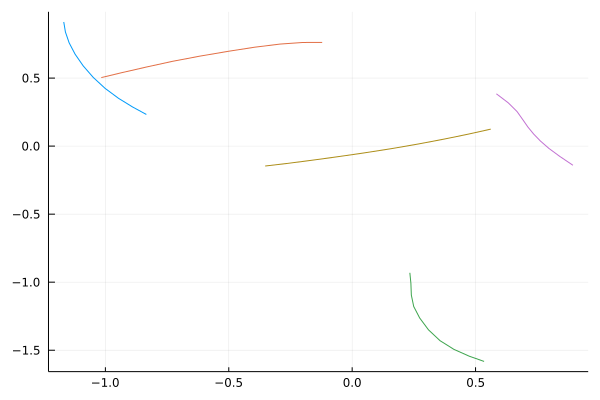

(layers[i], hidden[i]) = (6, 100)


In [ ]:
layers = [6]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [2]:
[3.64, 8.38, 365.735621851, 1660.5172351150002, 12.35, 239.97875070499998, 1440.967892535] / 50

7-element Array{Float64,1}:
  0.0728
  0.16760000000000003
  7.314712437020001
 33.210344702300006
  0.247
  4.799575014099999
 28.819357850699998

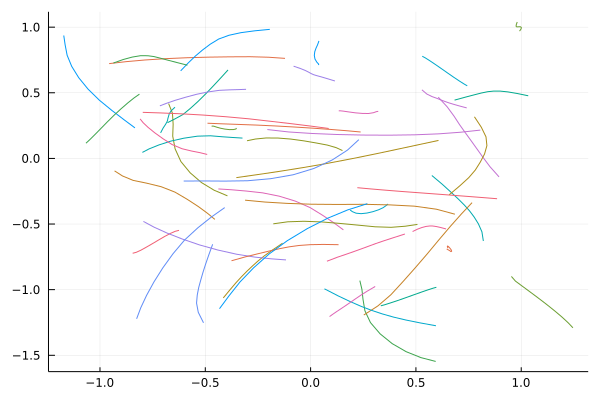

(layers[i], hidden[i]) = (3, 200)
(mean_cost, std_cost, tot_time) = 

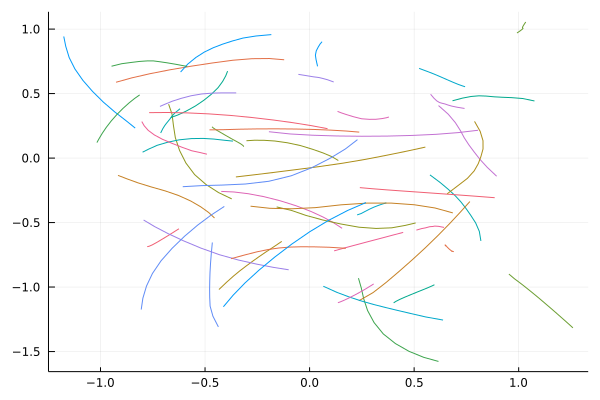

(1.0120751025913949e-8, 2.1806430671543564e-8, 3246.021960962)
(layers[i], hidden[i]) = (3, 300)


In [ ]:
layers = [3,3,4,5]
hidden = [200, 300, 100, 100]
for i in 1:4
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)
end

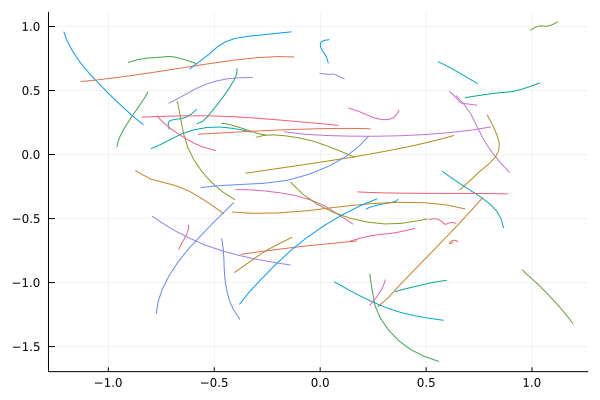

(name, mean_cost, std_cost, tot_time) = ("MIND", 2.7328601854516227e-6, 5.77566257362756e-5, 81.50541812299998)
(name, mean_cost, std_cost, tot_time) = ("shoot_1000", 0.13343616564152408, 0.08418422823646443, 2.59692713)
(name, mean_cost, std_cost, tot_time) = ("shoot_10000", 0.04239372840681775, 0.02763579087828977, 23.303232628999996)


LoadError: [91mInterruptException:[39m

In [13]:
net_path = "../nnet/unicycle-FC3-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

In [ ]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

In [ ]:
net_path = "../nnet/unicycle-FC4-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

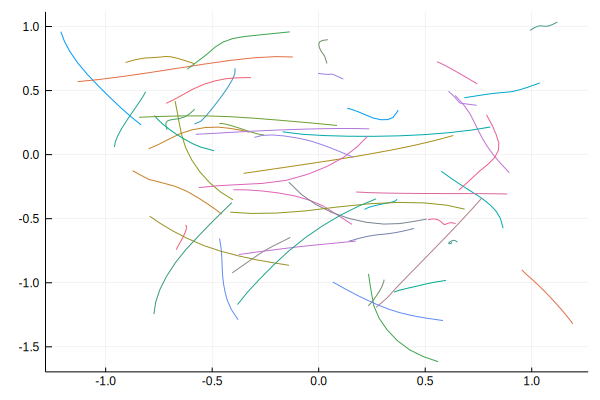

(mean_cost, std_cost, tot_time) = (1.0895788559974612e-8, 3.083755027102314e-8, 50.390301906999994)
(mean_cost, std_cost, tot_time) = (0.12969996782949633, 0.08054006985445446, 2.056006229)
(mean_cost, std_cost, tot_time) = (0.04136016129611548, 0.02650465274419478, 18.877258890000004)
(mean_cost, std_cost, tot_time) = (0.012447531370764039, 0.00787737761914061, 192.70776031099996)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

(mean_cost, std_cost, tot_time) = (1.8716195571270666, 0.6261442962556351, 18.422422558)
(mean_cost, std_cost, tot_time) = (1.871619557220702, 0.6261442962866007, 14.105904870000002)


(Any[1.0895788559974612e-8, 0.12969996782949633, 0.04136016129611548, 0.012447531370764039, 1.8716195571270666, 1.871619557220702], Any[3.083755027102314e-8, 0.08054006985445446, 0.02650465274419478, 0.00787737761914061, 0.6261442962556351, 0.6261442962866007], Any[50.390301906999994, 2.056006229, 18.877258890000004, 192.70776031099996, 18.422422558, 14.105904870000002])

In [5]:
net_path = "../nnet/unicycle-FC3-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

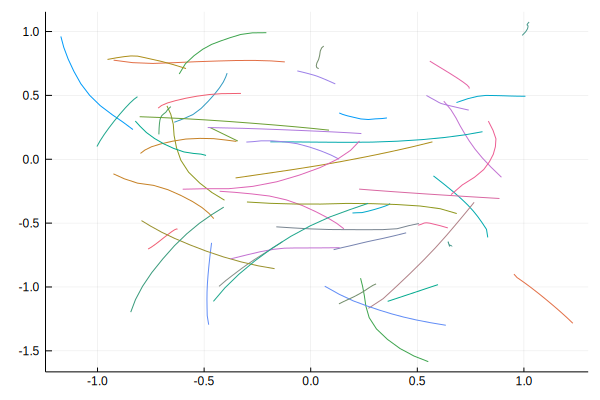

(mean_cost, std_cost, tot_time) = (6.489099810321613e-9, 1.977044452870109e-8, 83.77855461800002)
(mean_cost, std_cost, tot_time) = (0.1284852426391819, 0.08074564136185328, 10.005950964000002)
(mean_cost, std_cost, tot_time) = (0.04145651698209728, 0.02682154645368886, 100.19791966099999)
(mean_cost, std_cost, tot_time) = (0.012368349096048519, 0.007841982353836362, 1006.2647876510001)
(mean_cost, std_cost, tot_time) = (1.8527095218638485, 0.6192430470781894, 3.9519386940000003)
(mean_cost, std_cost, tot_time) = (1.8527095220875787, 0.6192430471562185, 16.299819683000003)


(Any[6.489099810321613e-9, 0.1284852426391819, 0.04145651698209728, 0.012368349096048519, 1.8527095218638485, 1.8527095220875787], Any[1.977044452870109e-8, 0.08074564136185328, 0.02682154645368886, 0.007841982353836362, 0.6192430470781894, 0.6192430471562185], Any[83.77855461800002, 10.005950964000002, 100.19791966099999, 1006.2647876510001, 3.9519386940000003, 16.299819683000003])

In [10]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

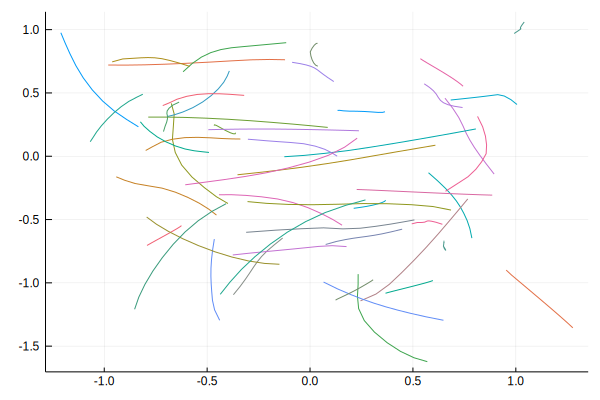

(mean_cost, std_cost, tot_time) = (7.578618859598388e-9, 1.5383480439942885e-8, 123.97852156799996)
(mean_cost, std_cost, tot_time) = (0.12857496457396428, 0.08016104194199944, 2.7265474340000004)
(mean_cost, std_cost, tot_time) = (0.04170528429248156, 0.02651888167336649, 27.34568216700001)
(mean_cost, std_cost, tot_time) = (0.012454351167091869, 0.007900240123822323, 272.4250334050001)
(mean_cost, std_cost, tot_time) = (1.8657904100085392, 0.6237601427277782, 3.5084003669999997)
(mean_cost, std_cost, tot_time) = (1.8657904101049583, 0.6237601427620205, 14.396685873000003)


(Any[7.578618859598388e-9, 0.12857496457396428, 0.04170528429248156, 0.012454351167091869, 1.8657904100085392, 1.8657904101049583], Any[1.5383480439942885e-8, 0.08016104194199944, 0.02651888167336649, 0.007900240123822323, 0.6237601427277782, 0.6237601427620205], Any[123.97852156799996, 2.7265474340000004, 27.34568216700001, 272.4250334050001, 3.5084003669999997, 14.396685873000003])

In [6]:
net_path = "../nnet/unicycle-FC4-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

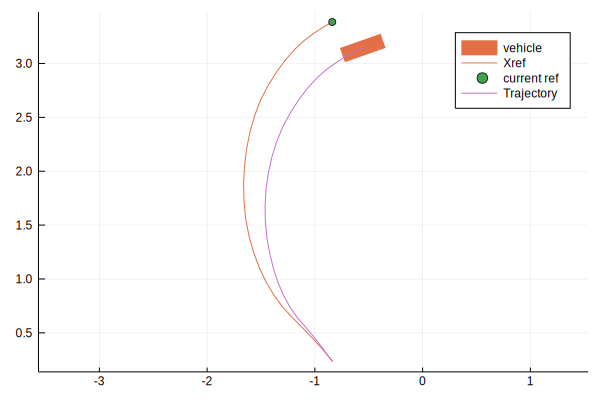

mean(costs(tp, Xtrack)) = 2.1937339953435013


2.1937339953435013

In [11]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obj_cost = [1,1,10,10];
Random.seed!(127);

tf = 3
T = 30
Xrefs, Urefs = generate_random_traj(net, 1, tf, T);
Xref=Xrefs[1]
tp = TP(net, obj_cost, tf, Xref);

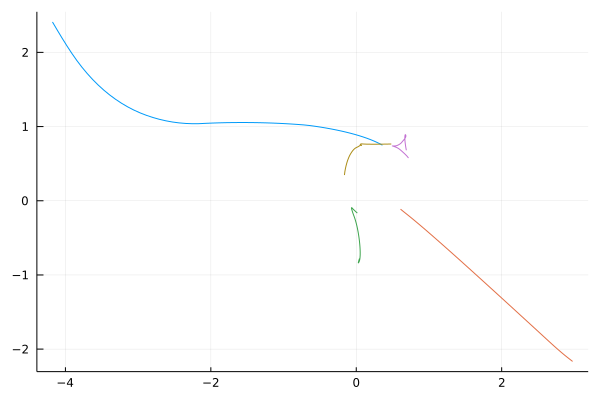

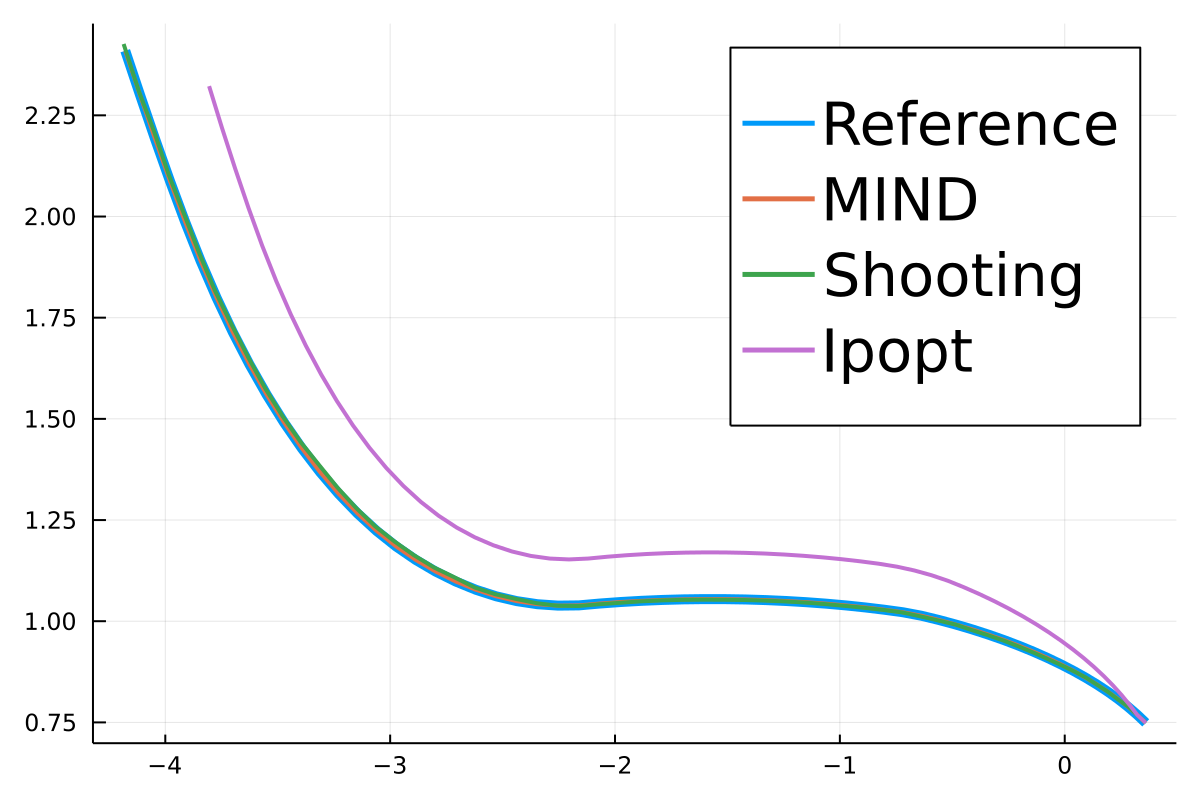

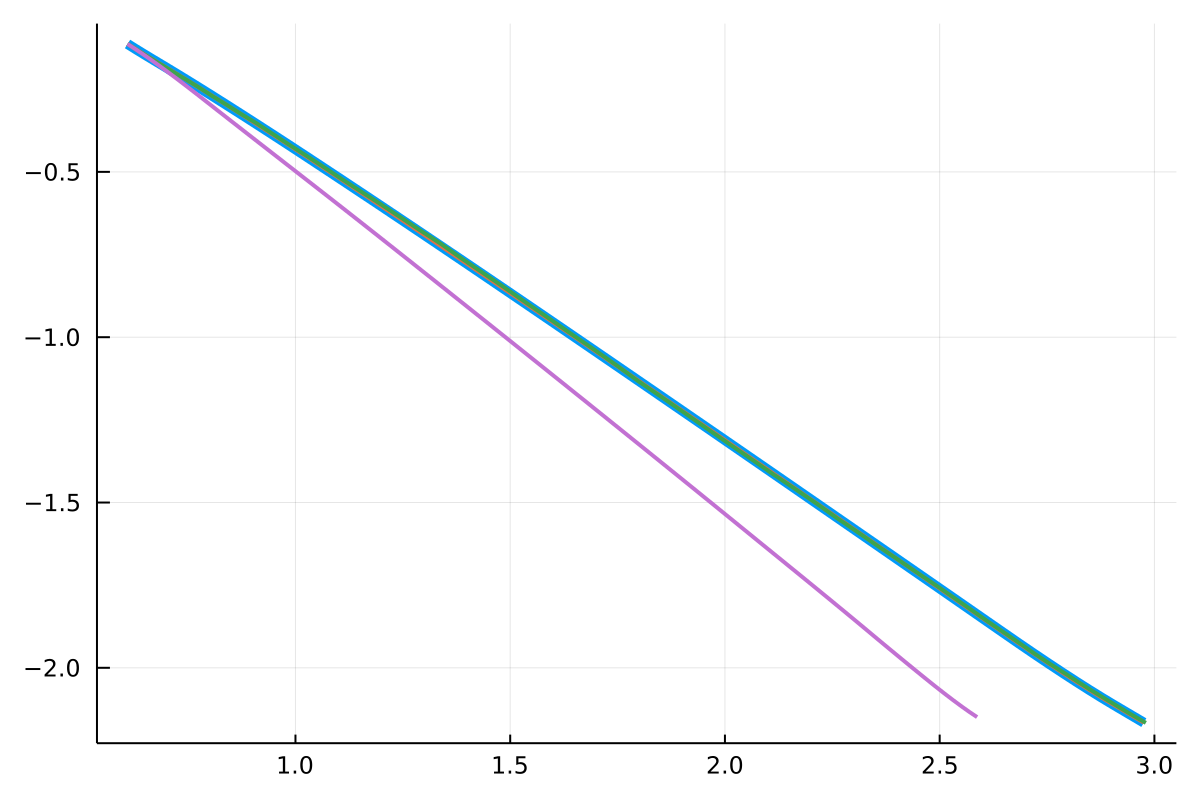

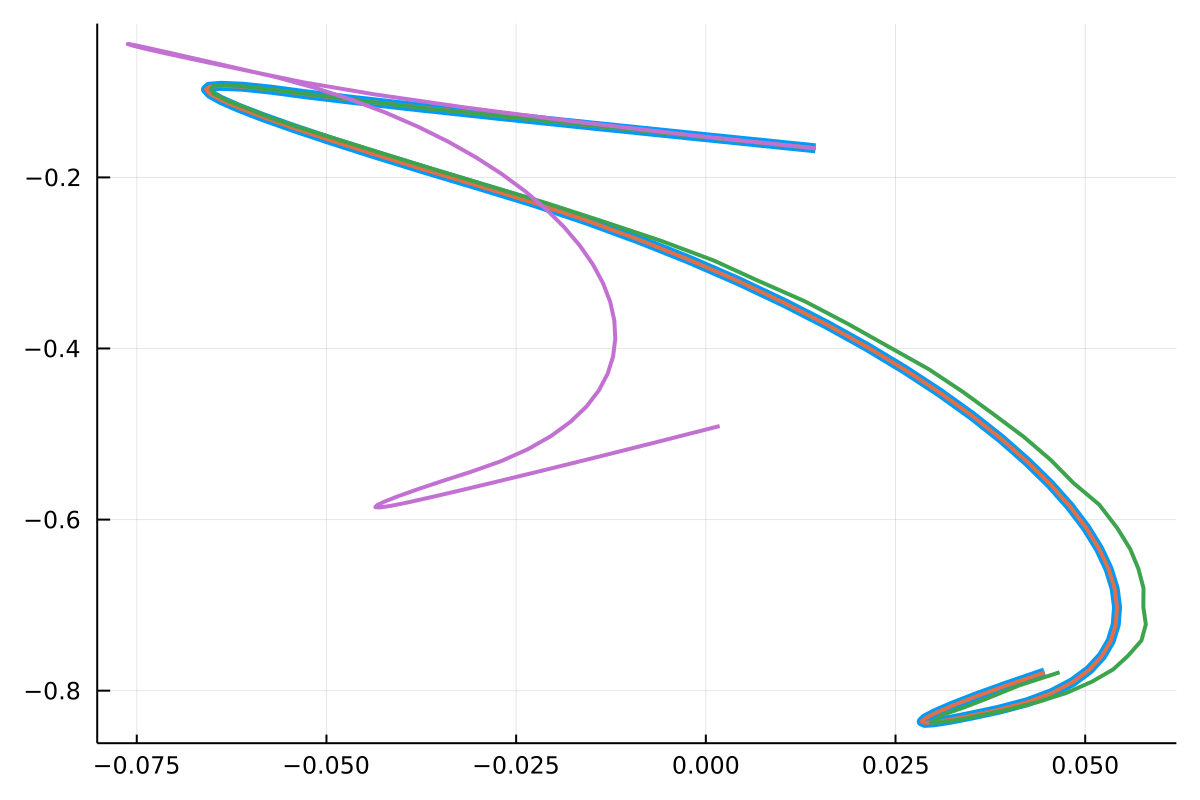

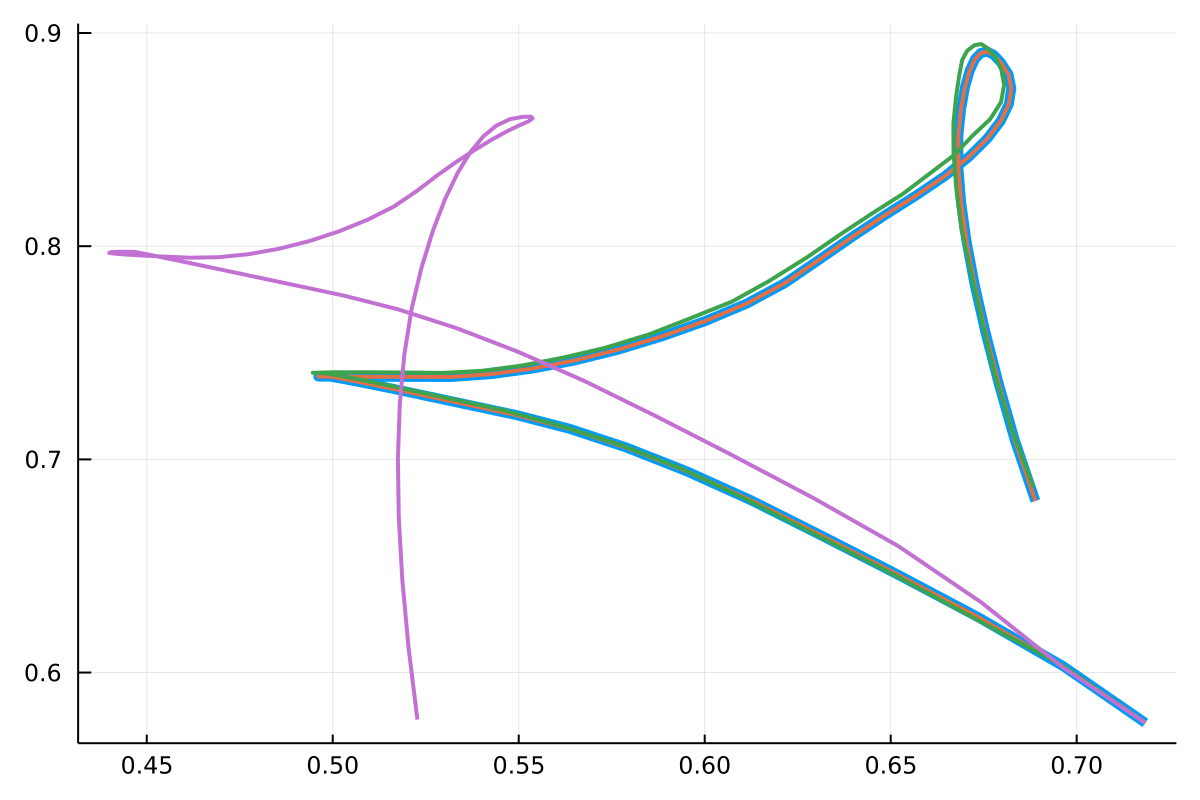

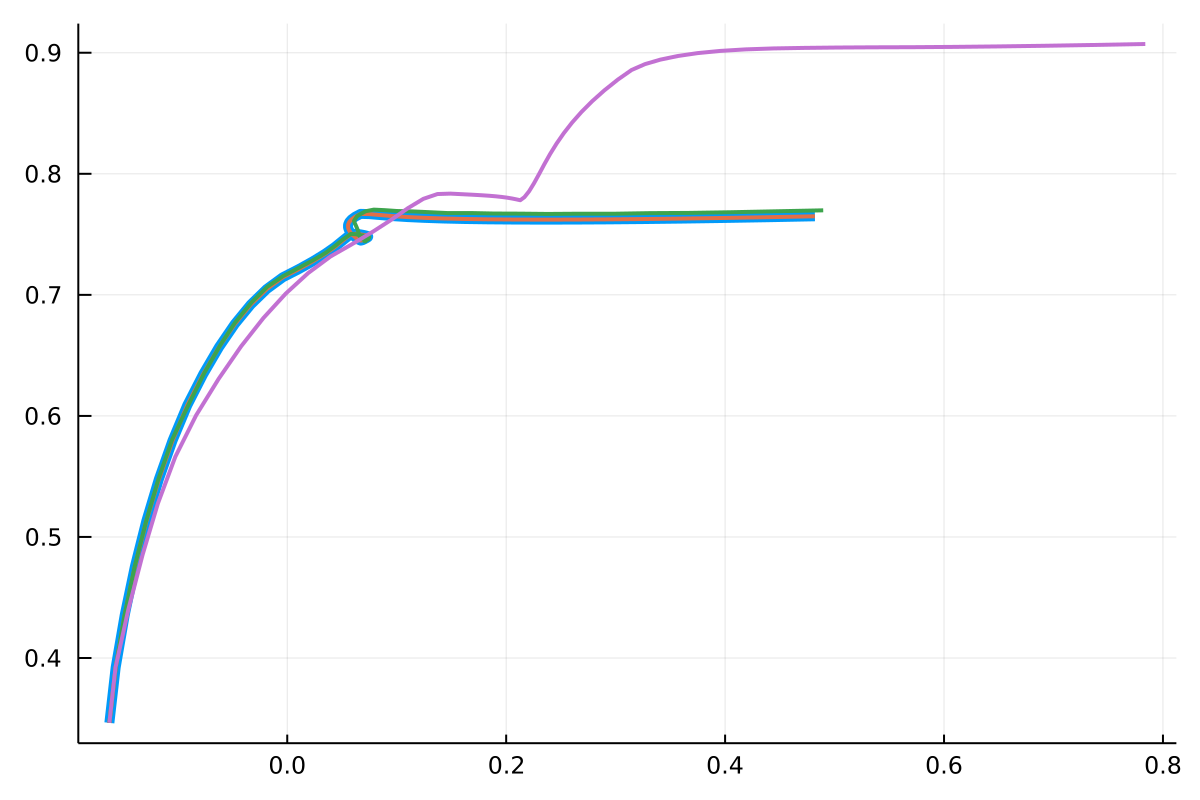


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [5]:
function draw_tracking_compare(net_path, tf, T, num;)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    p = plot()
    for k = 1:num
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, legend = false)
    end
    display(p)
    
    err_bound = [1, 1, 0.1, 0.1]*100
    nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
    nl_ctrl_original = NlController(err_bound, warm_start=false)
    err_bound = [1, 1, 0.1, 0.1]*1
    nl_ctrl_bounded = NlController(err_bound, warm_start=true)
    shoot_100 = ShootingController(100);
#     ctrls = [nv_ctrl, shoot_100, nl_ctrl_original]
#     labels = ["MIP", "Shooting", "Ipopt original"]
    ctrls = [nv_ctrl, shoot_100, nl_ctrl_bounded]
    labels = ["MIND", "Shooting", "Ipopt"]
    
    for k = 1:num
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
#         p = plot(dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
        display(p)
        savefig("../results/tracking_bounded_"*string(k)*".png")
    end
end
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5)

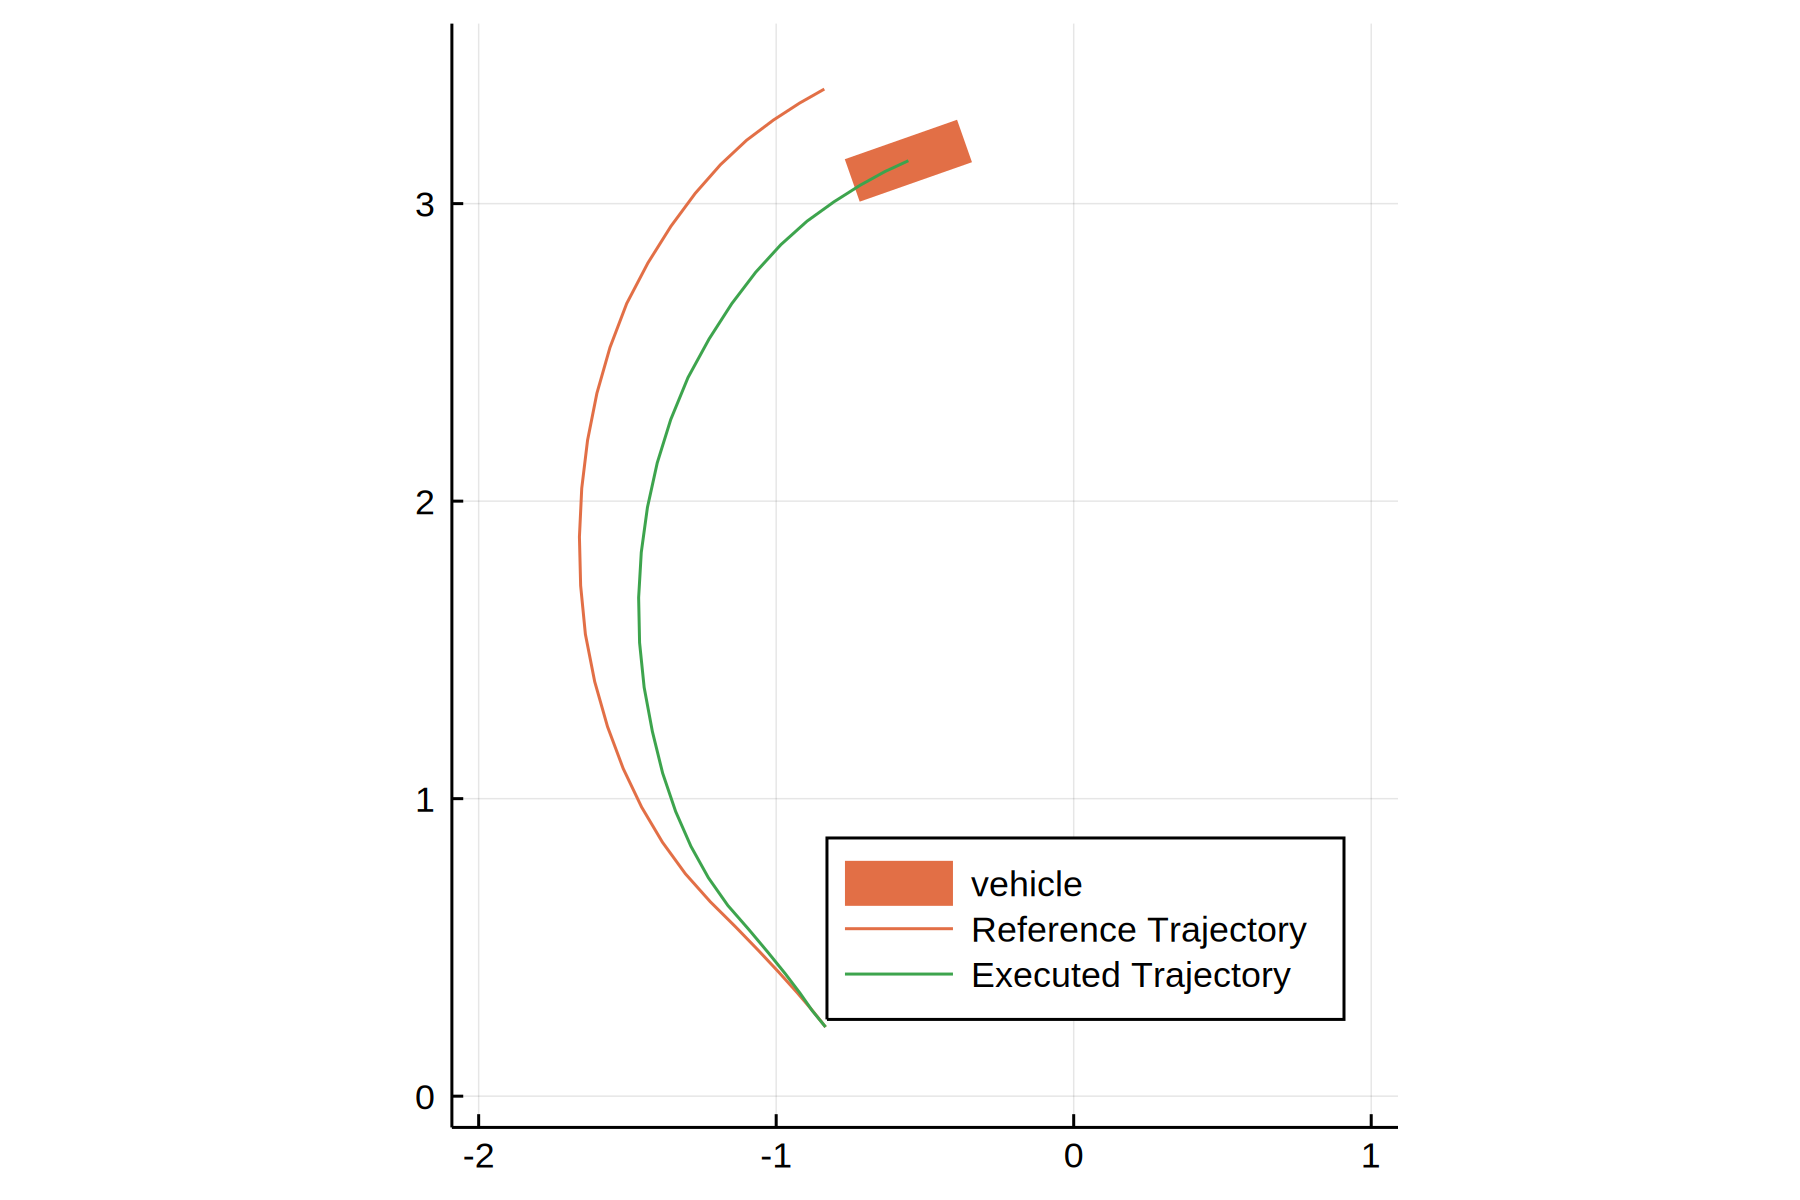

mean(costs(tp, Xtrack)) = 2.1937339953435013


2.1937339953435013

In [62]:
err_bound = [1, 1, 0.1, 0.1]
nl_iter_ctrl = NlController(err_bound, iter=5)
ctrl = nl_iter_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_nl.png"))
@show mean(costs(tp, Xtrack))

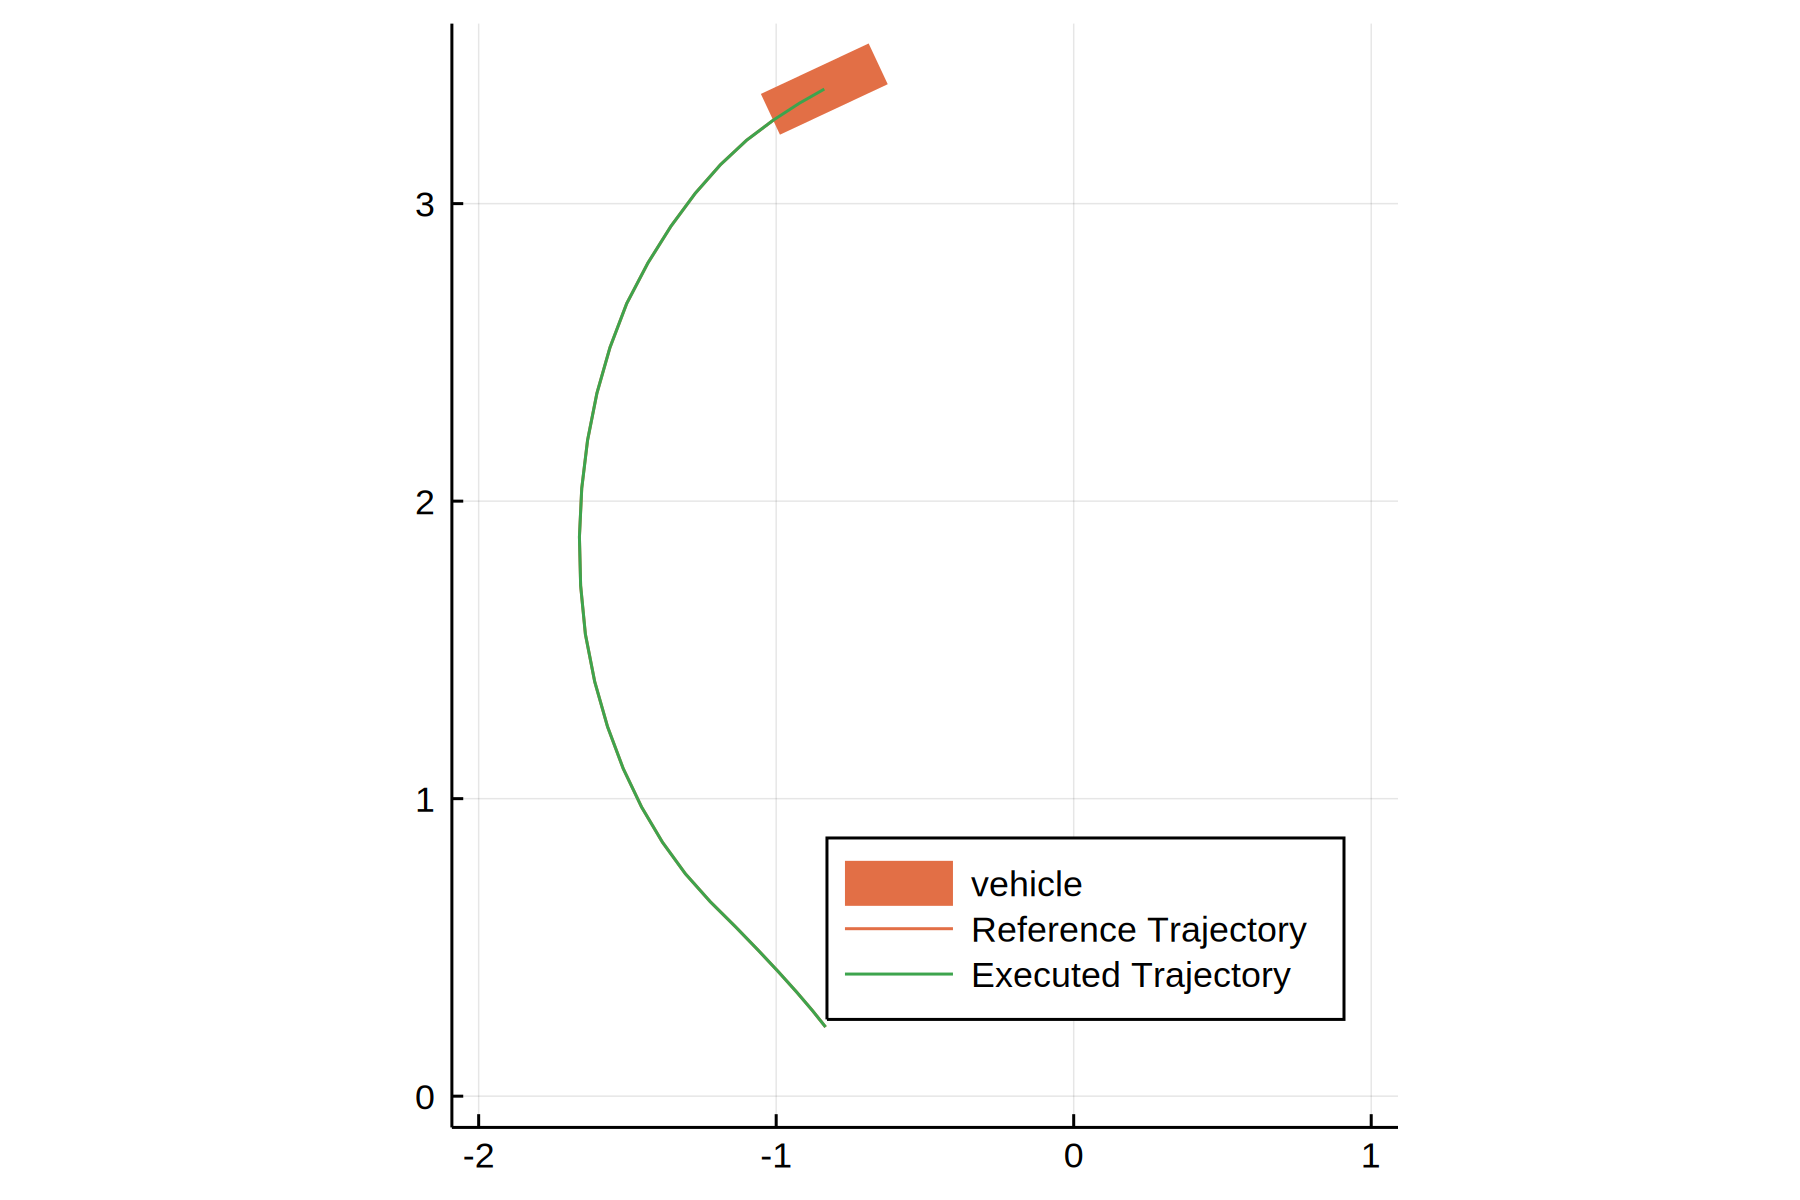

mean(costs(tp, Xtrack)) = 4.5020973097701735e-9


4.5020973097701735e-9

In [67]:
tp = TP(net, obj_cost, tf, Xref);
err_bound = [1, 1, 0.1, 0.1]
err_bound = [1, 1, 0.1, 0.1]
nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
ctrl = nv_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_nv.png"))
@show mean(costs(tp, Xtrack))

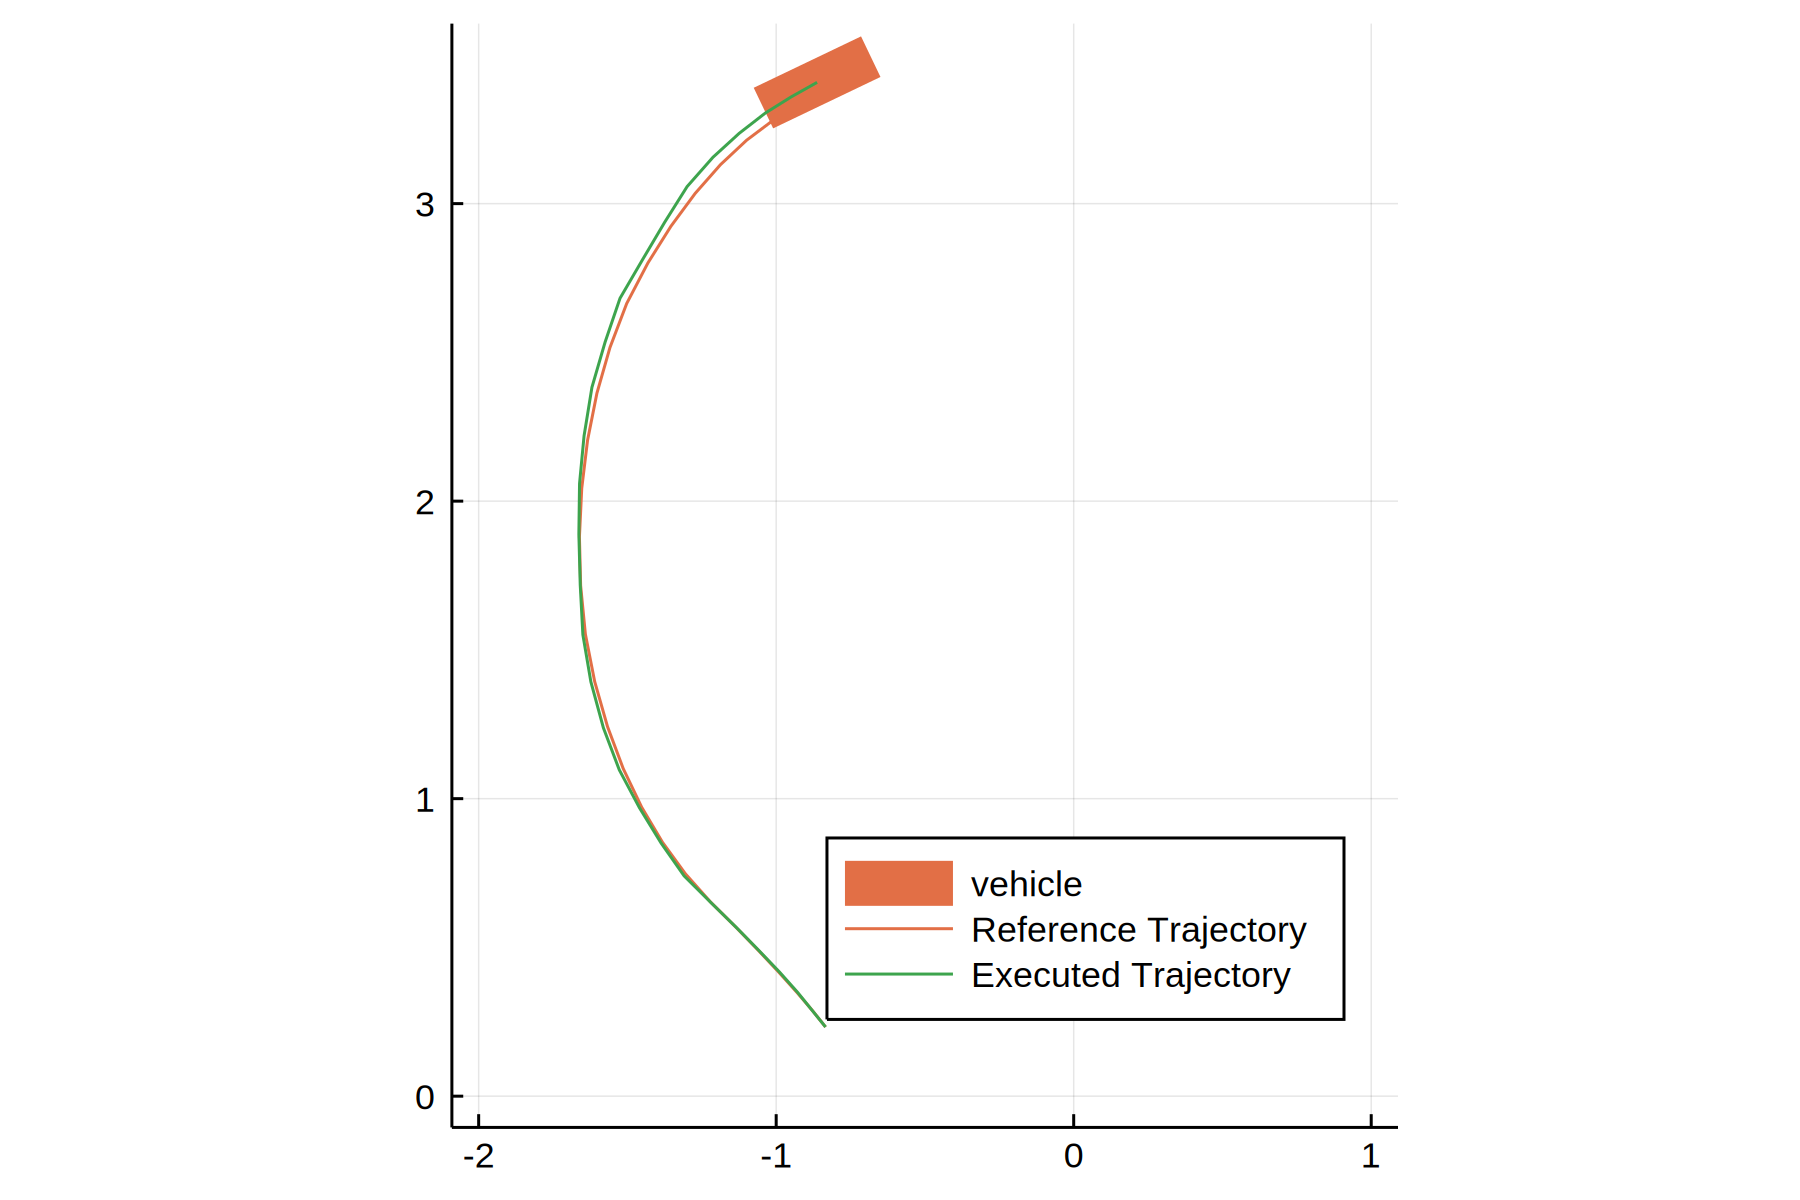

mean(costs(tp, Xtrack)) = 0.5108353752102361


0.5108353752102361

In [68]:
tp = TP(net, obj_cost, tf, Xref);
shoot_ctrl = ShootingController(100)
ctrl = shoot_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_shoot.png"))
@show mean(costs(tp, Xtrack))

In [7]:
function draw_tracking_compare(net_path, tf, T, num;)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    p = plot()
    for k = 1:num
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, legend = false)
    end
    display(p)
    
    err_bound = [1, 1, 1, 1]*100
    nv_ctrl = NvController(err_bound, warm_start=false, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_100 = ShootingController(100);
    ctrls = [nv_ctrl, shoot_100, nl_ctrl]
    labels = ["MIND", "Shooting", "Ipopt_original"]
    
    for k = 1:num
        if k != 1 && k != 3 && k != 4
            continue
        end
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
#         p = plot(dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        Utracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            push!(Utracks, Utrack)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
#         display(p)
#         savefig("../results/tracking_traj_"*string(k)*".png")
        
        p1 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        p2 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        for i = 1:length(Utracks)
            uv = [u[1] for u in Utracks[i]]
            ua = [u[2] for u in Utracks[i]]
            plot!(p1, uv, label=labels[i], linewidth=2, legendfontsize=20)
            plot!(p2, ua, label=labels[i], linewidth=2, legendfontsize=20)
        end
        xlabel!(p1, "time step")
        xlabel!(p2, "time step")
        ylabel!(p1, "control 1")
        ylabel!(p2, "control 2")
        l = @layout [a; b]
        plot(p1, p2, layout = l, dpi=200)
        savefig("../results/tracking_original_control_"*string(k)*".png")
    end
end

draw_tracking_compare (generic function with 1 method)

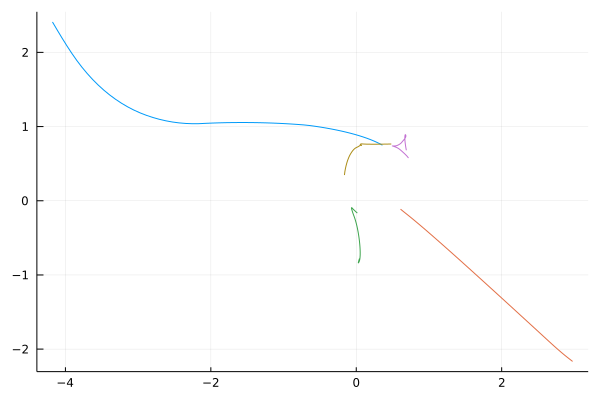

In [8]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5)

In [8]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obj_cost = [1,1,10,10];
Random.seed!(127);

tf = 3
T = 30
Xrefs, Urefs = generate_random_traj(net, 1, tf, T);
Xref=Xrefs[1]
tp = TP(net, obj_cost, tf, Xref);

In [10]:

Utracks = []

ctrl = ShootingController(100)
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
push!(Utracks, Utrack)

ctrl = ShootingController(1000)
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
push!(Utracks, Utrack)

2-element Array{Any,1}:
 [[1.5999438086216191, -0.334021170987465], [0.38852575072094275, 1.009832809597385], [0.8652583060555177, -0.09249280241837532], [1.044875258115212, -0.08520201207427913], [0.7483486942855446, 0.5556508617770421], [1.035482705511864, -0.8662391504731453], [1.1716653532201402, -1.0953474207791256], [0.5712719630948904, -0.7630119417867691], [0.8246537899979227, -0.8452484495417787], [0.1643520641988978, -0.8889135118579241]  …  [-0.4634384227696682, -0.17511947108326575], [-0.5162670900406621, -0.7725493194269233], [-0.819840242531825, -0.9607231583225988], [-0.5605957185088712, -0.8684738761775215], [-0.655462724224801, -0.6462004944306896], [-1.5793558138189496, -0.9673606053853563], [0.18722424206766775, -0.9019050241604352], [-1.7884520385569456, -0.9902812480052647], [-0.8048808703842596, -0.6526191282127218], [-1.6061414640313991, -0.8902370556259953]]
 [[0.9862752356377396, 0.030298910385553768], [0.9059350679851423, 0.2783563807870877], [1.06065992248550

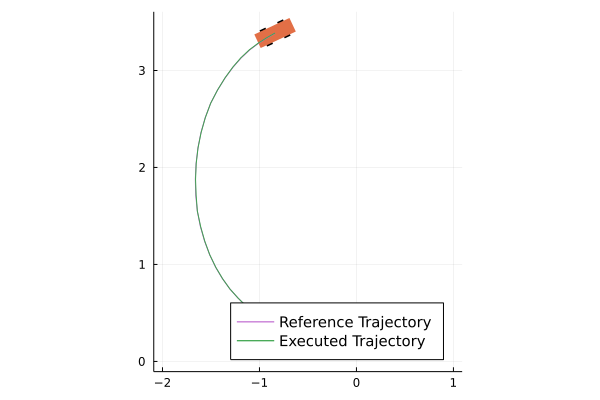

true

In [11]:
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5])

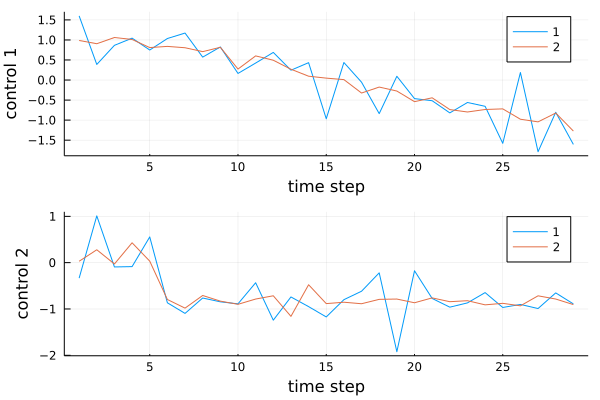

In [21]:
p1 = plot()
p2 = plot()
for i = 1:length(Utracks)
    uv = [u[1] for u in Utracks[i]]
    ua = [u[2] for u in Utracks[i]]
    plot!(p1, uv, label=string(i))
    plot!(p2, ua, label=string(i))
end
xlabel!(p1, "time step")
xlabel!(p2, "time step")
ylabel!(p1, "control 1")
ylabel!(p2, "control 2")
l = @layout [a; b]
plot(p1, p2, layout = l)